In [1]:
from functions import *
from utility_functions import *



from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB


from sklearn.mixture import GaussianMixture

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy


import networkx as nx
from matplotlib.pyplot import figure, text
from matplotlib import gridspec

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib import cm

import os
import datetime




import seaborn as sns

import re

from collections import defaultdict

from geopy.geocoders import Nominatim

from community import community_louvain

import sys

import csv



import random

from tempfile import TemporaryFile


import country_converter as coco



import pickle

from mpl_toolkits.basemap import Basemap
import time
from multiprocessing import Pool


2024-02-26 13:01:46.510048: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-26 13:01:46.694620: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /shared/centos7/anaconda3/2022.05/lib:/shared/centos7/nodejs/14.15.4/lib
2024-02-26 13:01:46.694654: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-26 13:01:48.224475: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'

In [2]:
def region_format_for_here(list_of_places):
    new_list=[]
    for i in list_of_places:
        if i=='USA':
            new_list.append('United States')
        elif i=='CzechRepublic':
            new_list.append('Czechia')
        elif i=='DRC':
            new_list.append('Democratic Republic of the Congo')
        elif i=='Korea, Republic of':
            new_list.append('South Korea')
        elif i=='Russian Federation':
            new_list.append('Russia')
        elif i=='Czech Republic':
            new_list.append('Czechia')            
        elif i=='Gambia':
            new_list.append('The Gambia')
        elif i=='Macedonia, the former Yugoslav Republic of':
            new_list.append('North Macedonia')
        elif i=='Taiwan, Province of China':
            new_list.append('Taiwan')    
        elif i=='Venezuela, Bolivarian Republic of':
            new_list.append('Venezuela')               
        elif i=='Iran, Islamic Republic of':
            new_list.append('Iran')    
        elif i=='Viet Nam':
            new_list.append('Vietnam')    
        elif i.upper()==i:
            new_list.append(i)
        else:
            new_list.append(' '.join(re.findall('[A-Z][^A-Z]*',i)))
    
    new_new_list=[]#remove double splitting
    for i in new_list:
        new_new_list.append(' '.join(i.split()))
    
    return new_new_list



# Read the saved dataframe with month column

In [3]:
#start_month='2020-08'
#threshold,sample_size,kmer=100,100,15

start_month='2020-08'
threshold,sample_size,kmer=100,100,100
target='country'


'''
start_month='2020-09'
threshold=200
sample_size=200
kmer=25
'''

"\nstart_month='2020-09'\nthreshold=200\nsample_size=200\nkmer=25\n"

In [4]:
Total_distance_dict={}
Even_dist_sum_dict={}

# load accuracy results


In [5]:
path=f'cross_validation_prediction/accuracy_true_BinaryNB_{target}level_cv5fold_start{start_month}_threshold{threshold}_SampleSize{sample_size}_kmer{kmer}.pickle'

with open(path, 'rb') as handle:
    accuracy_true = pickle.load(handle)
    
path=f'cross_validation_prediction/accuracy_pred_BinaryNB_{target}level_cv5fold_start{start_month}_threshold{threshold}_SampleSize{sample_size}_kmer{kmer}.pickle'

with open(path, 'rb') as handle:
    accuracy_predicted = pickle.load(handle)

In [6]:
region_list=list(accuracy_true.keys())

accuracy_predicted_true_avg=defaultdict()
for region_i in region_list:
    accuracy_predicted_true_avg[region_i]=(accuracy_predicted[region_i]+accuracy_true[region_i])/2
accuracy_predicted_true_avg=dict(zip(region_format_for_here(list(accuracy_predicted_true_avg.keys())),list(accuracy_predicted_true_avg.values())))
print(np.mean(list(accuracy_predicted_true_avg.values())))

# Compute centrality from the flight data
# df_flights is filtered by the startmonth

In [20]:
df_flights = pandas.read_csv('data/OAG_country-flight-network_201912-202103.csv',header=0)
# filter by dates to keep consistency to the misclassification data
df_flights=df_flights[df_flights['Time Series']>=int(start_month[:4]+start_month[-2:])]
sorted(set(df_flights['Time Series']))

[202008, 202009, 202010, 202011, 202012, 202101, 202102, 202103]

In [21]:

df_flights_aggregated=df_flights.groupby(['Dep Country Code', 'Arr Country Code']).sum().reset_index()

df_flights_aggregated.drop(columns=['Time Series'])

,Dep Country Code,Arr Country Code,Total Est. Pax
0,AE,AE,3441
1,AE,AF,64282
2,AE,AG,35
3,AE,AL,1683
4,AE,AM,14452
...,...,...,...
25576,ZW,UZ,11
25577,ZW,VN,1
25578,ZW,ZA,78889
25579,ZW,ZM,11642


In [ ]:
#non-weighted adj
A_flights=pd.crosstab(df_flights_aggregated['Dep Country Code'], df_flights_aggregated['Arr Country Code'])
A_flights

In [23]:
Dep=list(set(df_flights_aggregated['Dep Country Code']))
Arr=list(set(df_flights_aggregated['Arr Country Code']))

In [24]:
country2code = {}
code2country = {}

with open("data/wikipedia-iso-country-codes.csv") as f:
    file= csv.DictReader(f, delimiter=',')
    for line in file:
        country2code[line['English short name lower case']] = line['Alpha-2 code']        
        code2country[line['Alpha-2 code'] ]=line['English short name lower case']
df_flights_aggregated['Dep Country Code']

0        AE
1        AE
2        AE
3        AE
4        AE
         ..
25576    ZW
25577    ZW
25578    ZW
25579    ZW
25580    ZW
Name: Dep Country Code, Length: 25581, dtype: object

In [25]:
#Only include locations that are also in the "data/wikipedia-iso-country-codes.csv" file
#this should be sufficient for the misclassification comparion
G_flights = nx.Graph()
list_weighted_edges=[]
Dep_filtered=[i for i in list(Dep) if i in list(code2country.keys())]
Arr_filtered=[i for i in list(Arr) if i in list(code2country.keys())]


for dep in Dep_filtered:
    for arr in Arr_filtered:
        dep_country=code2country[dep]
        arr_country=code2country[arr]
        try:
            if A_flights[dep][arr]>0:
                w=int(df_flights_aggregated[(df_flights_aggregated["Dep Country Code"] == dep) & (df_flights_aggregated["Arr Country Code"] == arr)]['Total Est. Pax'])
                list_weighted_edges.append((dep_country,arr_country,w))
        except:
            pass
        
G_flights.add_weighted_edges_from(list_weighted_edges)

node_list=list(G_flights.nodes())
formatted_nodes=region_format_for_here(node_list)

mapping=dict(zip(node_list,formatted_nodes))
G_flights = nx.relabel_nodes(G_flights, mapping)

degree=nx.degree_centrality(G_flights)
eigenvector_centrality=nx.eigenvector_centrality(G_flights)
closeness_centrality=nx.closeness_centrality(G_flights)
betweenness_centrality=nx.betweenness_centrality(G_flights)


region_list_formatted=region_format(region_list)   

print([i for i in region_list_formatted if i not in list(set(degree.keys()))])
print(len([i for i in region_list_formatted if i not in list(set(degree.keys()))]))
print(len(region_list_formatted)-len([i for i in region_list_formatted if i not in list(set(degree.keys()))]))

# accuracy_pred and accuracy_true are actually the same !!! 

In [33]:
keys1 = list(set(degree.keys()) & set(accuracy_predicted_true_avg.keys()))
print(len(keys1))

64


In [34]:
degree_measure=degree
#accuracy_predicted_true_avg
keys1 = list(set(degree.keys()) & set(accuracy_predicted_true_avg.keys()))
x=[degree[region_i] for region_i in keys1]
y=[accuracy_predicted_true_avg[region_i] for region_i in keys1]

print('pearsonr',scipy.stats.pearsonr(x, y))
print('spearmanr',scipy.stats.spearmanr(x, y))
print('kendalltau',scipy.stats.kendalltau(x, y) )

pearsonr PearsonRResult(statistic=-0.45070990280610734, pvalue=0.00018597302209737209)
spearmanr SignificanceResult(statistic=-0.5496679759507133, pvalue=2.548663073081798e-06)
kendalltau SignificanceResult(statistic=-0.38366024772208435, pvalue=8.099506890688443e-06)


# after log transformation pearson's correlation is enlarged

In [35]:
centrality_measure=degree

keys1 = list(set(centrality_measure.keys()) & set(accuracy_true.keys()))
x=[centrality_measure[region_i] for region_i in keys1]
y=[np.log(1-accuracy_true[region_i]) for region_i in keys1]

print('pearsonr',scipy.stats.pearsonr(x, y))
print('spearmanr',scipy.stats.spearmanr(x, y))
print('kendalltau',scipy.stats.kendalltau(x, y) )

pearsonr PearsonRResult(statistic=0.3725060556728268, pvalue=0.0024356906226910635)
spearmanr SignificanceResult(statistic=0.5496679759507133, pvalue=2.548663073081798e-06)
kendalltau SignificanceResult(statistic=0.38366024772208435, pvalue=8.099506890688443e-06)


# compute association using other centralities

In [36]:
centrality_measure=eigenvector_centrality


keys2 = list(set(centrality_measure.keys()) & set(accuracy_true.keys()))
x=[centrality_measure[region_i] for region_i in keys2]
y=[np.log(1-accuracy_true[region_i]) for region_i in keys2]

print('pearsonr',scipy.stats.pearsonr(x, y))
print('spearmanr',scipy.stats.spearmanr(x, y))
print('kendalltau',scipy.stats.kendalltau(x, y) )

pearsonr PearsonRResult(statistic=0.3197777235880339, pvalue=0.01000025057264188)
spearmanr SignificanceResult(statistic=0.583797891497629, pvalue=4.1169410493825857e-07)
kendalltau SignificanceResult(statistic=0.4073431035788414, pvalue=1.9683819123639875e-06)


In [37]:


centrality_measure=closeness_centrality


keys2 = list(set(centrality_measure.keys()) & set(accuracy_true.keys()))
x=[centrality_measure[region_i] for region_i in keys2]
y=[np.log(1-accuracy_true[region_i]) for region_i in keys2]

print('pearsonr',scipy.stats.pearsonr(x, y))
print('spearmanr',scipy.stats.spearmanr(x, y))
print('kendalltau',scipy.stats.kendalltau(x, y) )

pearsonr PearsonRResult(statistic=0.416121385571106, pvalue=0.0006265042829768426)
spearmanr SignificanceResult(statistic=0.553978096386814, pvalue=2.047091326448561e-06)
kendalltau SignificanceResult(statistic=0.3870512690374798, pvalue=6.6991554785322135e-06)


In [38]:


centrality_measure=betweenness_centrality


keys2 = list(set(centrality_measure.keys()) & set(accuracy_true.keys()))
x=[centrality_measure[region_i] for region_i in keys2]
y=[np.log(1-accuracy_true[region_i]) for region_i in keys2]

print('pearsonr',scipy.stats.pearsonr(x, y))
print('spearmanr',scipy.stats.spearmanr(x, y))
print('kendalltau',scipy.stats.kendalltau(x, y) )

pearsonr PearsonRResult(statistic=0.1136086981912781, pvalue=0.37139936528501055)
spearmanr SignificanceResult(statistic=0.3784427299159779, pvalue=0.00204629580847826)
kendalltau SignificanceResult(statistic=0.25905707196029776, pvalue=0.002491496515168586)


In [39]:
centrality_measures_dict={'Degree':degree,'Eigenvector':eigenvector_centrality,'Closeness':closeness_centrality,'Betweenness':betweenness_centrality}


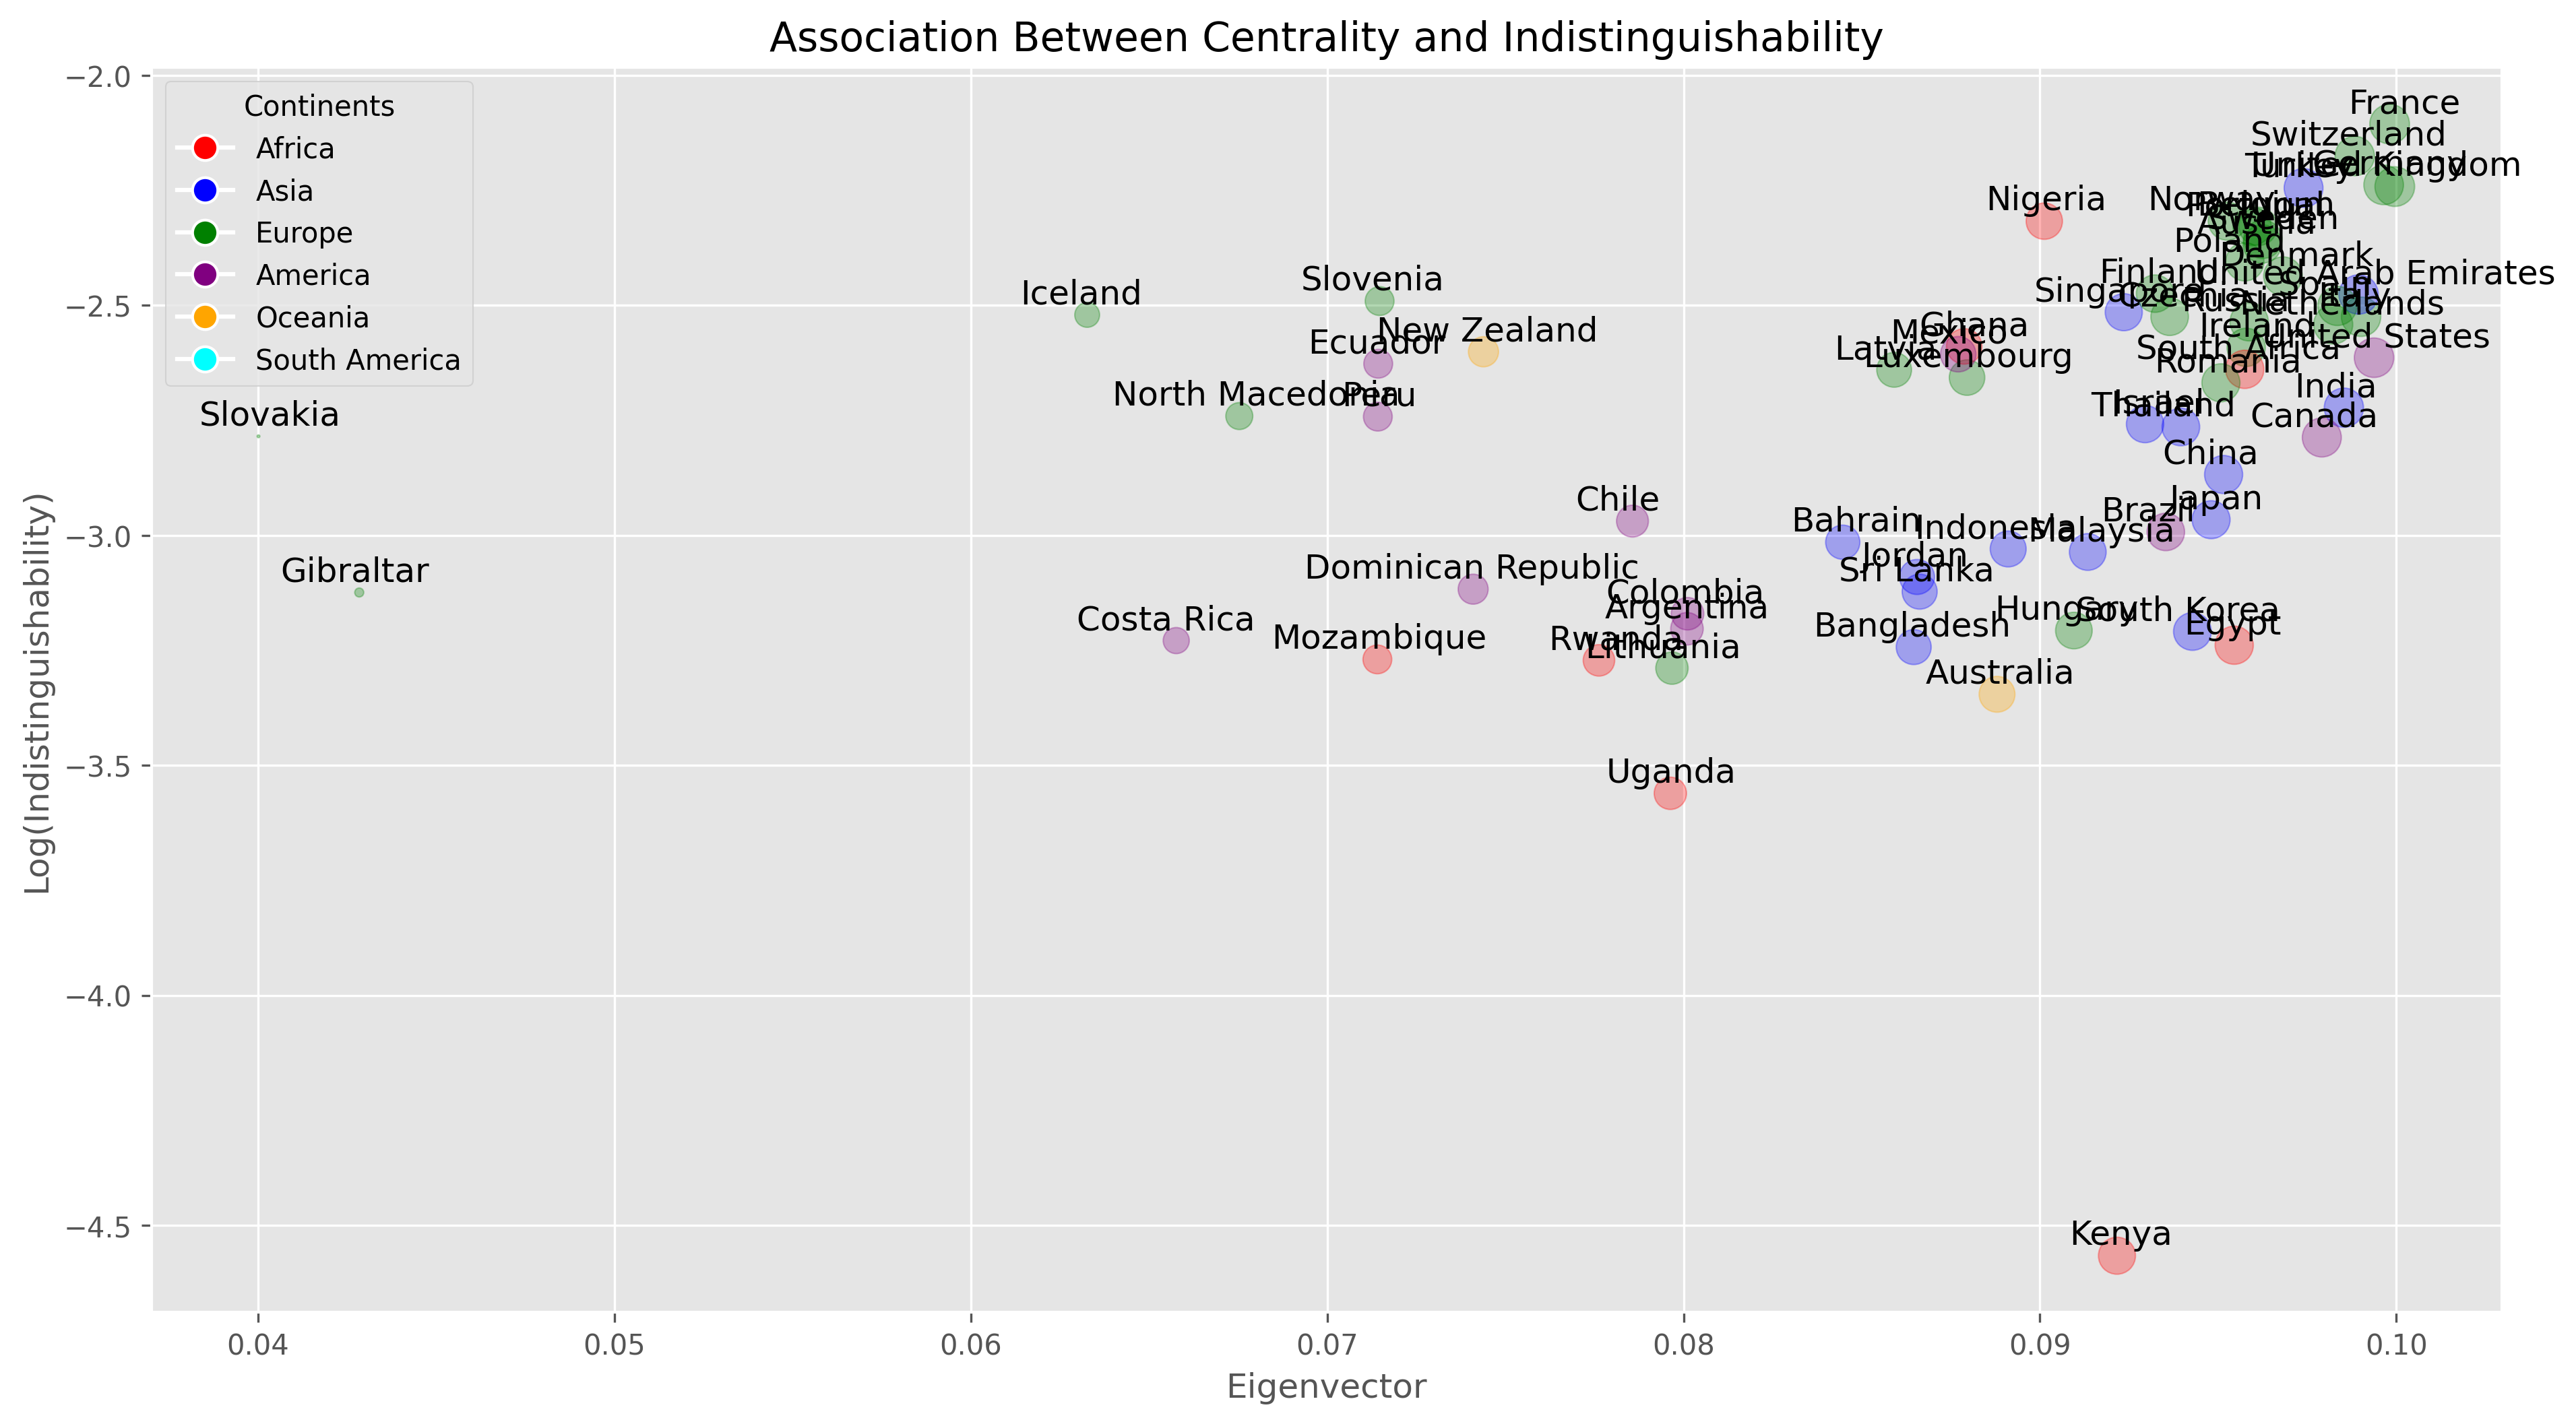

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import mplcursors
import country_converter as coco  


centrality_measure='Eigenvector'
centrality=centrality_measures_dict[centrality_measure]
#degree
#eigenvector_centrality
#closeness_centrality
#betweenness_centrality

keys2 = list(set(centrality.keys()) & set(accuracy_true.keys()))
x = [centrality[region_i] for region_i in keys2]
y = [np.log(1 - accuracy_true[region_i]) for region_i in keys2]
indistinguishability_values = y


cc = coco.CountryConverter()
continents = cc.convert(names=keys2, to='continent')

colormap = plt.get_cmap('viridis')

norm = plt.Normalize(vmin=min(indistinguishability_values), vmax=max(indistinguishability_values))

def color_function(indistinguishability):
    return colormap(norm(indistinguishability))

def size_function(centrality):
    min_size = 1
    max_size = 200
    return min_size + (max_size - min_size) * (centrality - min(x)) / (max(x) - min(x))

plt.style.use('default')
plt.style.use('ggplot')

plt.figure(figsize=(15, 8), dpi=300)  # You can adjust the dimensions as needed


# Jittering the annotations to reduce overlap
for i, country_i in enumerate(keys2):
    jitter_x = np.random.uniform(-0.0005, 0.0005) 
    jitter_y = np.random.uniform(-0.0005, 0.0005) 

    # Add annotation only for data points with high centrality or low indistinguishability
    if x[i] > 0.08 or y[i] < -1.0:
        plt.annotate(country_i, (x[i] + jitter_x, y[i] + jitter_y), textcoords="offset points", xytext=(0, 4), ha='center', fontsize=12)


plt.xlabel(centrality_measure)
plt.ylabel('Log(Indistinguishability)')
plt.title('Association Between Centrality and Indistinguishability')

continent_colors = {
    'Africa': 'red',
    'Asia': 'blue',
    'Europe': 'green',
    'America': 'purple',
    'Oceania': 'orange',
    'South America': 'cyan',
}

point_colors = [continent_colors.get(continent, 'gray') for continent in continents]

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=continent_colors[continent], markersize=9, label=continent) for continent in continent_colors]

scatter = plt.scatter(x, y, c=point_colors, s=[size_function(cent) for cent in x], alpha=0.3)
mplcursors.cursor(scatter, hover=True).connect("add", lambda sel: sel.annotation.set_text(keys2[sel.target.index]))

plt.legend(handles=legend_handles, title='Continents', loc='best')

plt.show()




In [46]:
cc = coco.CountryConverter()
continents = cc.convert(names=keys2, to='continent')


subregions = {
    'North America': ['Canada', 'United States', 'Mexico'],
    'South America': ['Peru', 'Bolivia', 'Colombia', 'Ecuador','Argentina', 'Chile', 'Uruguay', 'Paraguay','Brazil', 'Venezuela', 'Guyana', 'Suriname'],
    'Central America & Caribbean': ['Costa Rica', 'Dominican Republic']
}


def get_subregion(country):
    for subregion, countries in subregions.items():
        if country in countries:
            return subregion
    return "Unknown" 

continents_finer=[]
for i,j in enumerate(continents):
    if j =='America':
        print(keys2[i],get_subregion(keys2[i]))
        continents_finer.append(get_subregion(keys2[i]))
    else:
        continents_finer.append(j)


Brazil South America
Chile South America
Peru South America
Canada North America
Argentina South America
United States North America
Dominican Republic Central America & Caribbean
Colombia South America
Ecuador South America
Mexico North America
Costa Rica Central America & Caribbean


figures/Flightscentrality_indistinguishabiity/FlightsEigenvector_vs_indistinguishability_countrylevel_cv5fold_start2020-08_threshold100_SampleSize100_kmer100.png


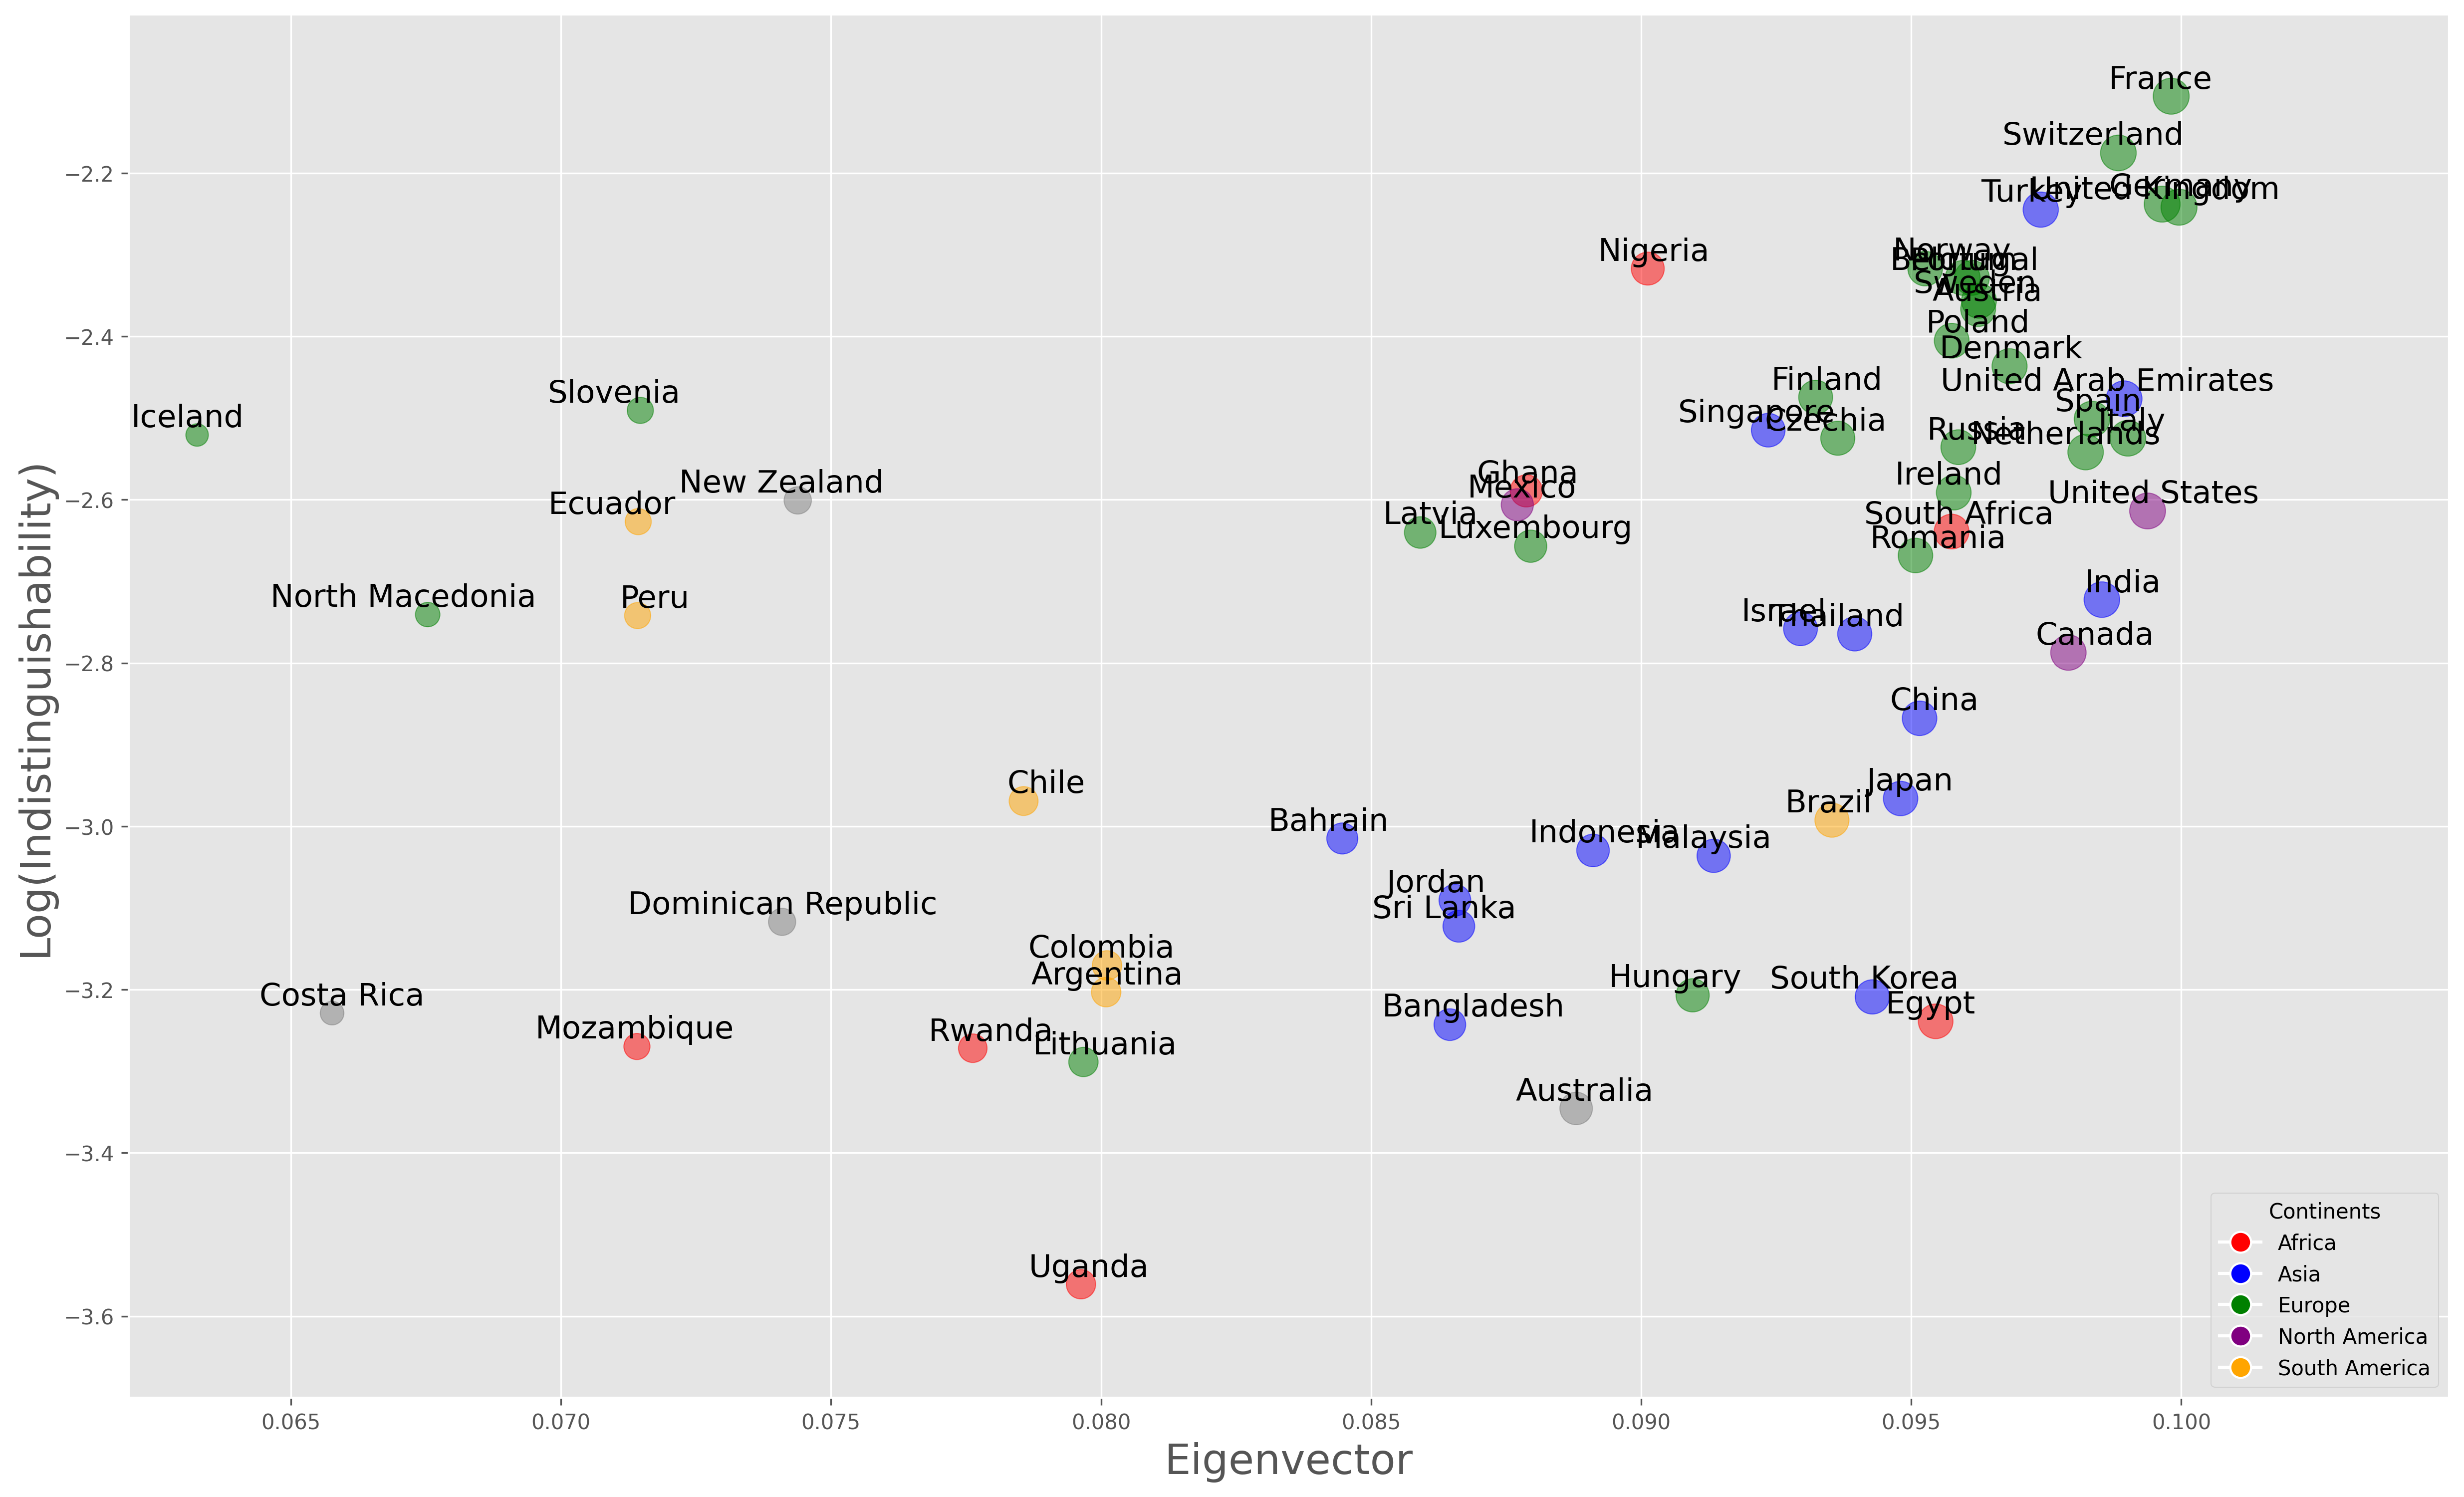

In [48]:
region_colors = {
    'Africa': 'red',
    'Asia': 'blue',
    'Europe': 'green',
    'North America': 'purple',
    'South America': 'orange',

}

keys2 = list(set(centrality.keys()) & set(accuracy_true.keys()))
x = [centrality[region_i] for region_i in keys2]
y = [np.log(1 - accuracy_true[region_i]) for region_i in keys2]


def size_function(centrality):
    min_size = 1
    max_size = 300
    return min_size + (max_size - min_size) * (centrality - min(x)) / (max(x) - min(x))


plt.figure(figsize=(20, 12), dpi=300)  
plt.style.use('ggplot')

# Jittering the annotations to reduce overlap
for i, country_i in enumerate(keys2):
    jitter_x = np.random.uniform(-0.0005, 0.0005)  
    jitter_y = np.random.uniform(-0.0005, 0.0005)  

    if x[i] > 0.08 or y[i] < -1.0:
        plt.annotate(country_i, (x[i] + jitter_x, y[i] + jitter_y), textcoords="offset points", xytext=(0, 4), ha='center', fontsize=15)

plt.xlabel(f'{centrality_measure}', fontsize=20)
plt.ylabel('Log(Indistinguishability)', fontsize=20)
#plt.title(f'Association Between {centrality_measure} and Indistinguishability')


point_colors = [region_colors.get(region, 'gray') for region in continents_finer]

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=region_colors[region], markersize=10, label=region) for region in region_colors]

scatter = plt.scatter(x, y, c=point_colors, s=[size_function(cent) for cent in x], alpha=0.5)

plt.legend(handles=legend_handles, title='Continents',loc='lower right')


plt.xlim(0.062, max(x) + 0.005)
#plt.ylim(-3, max(y) + 0.1)
#plt.xlim(min(x) - 0.01, max(x) + 0.005)
#plt.ylim(min(y) - 0.1, max(y) + 0.1)
#plt.xlim(0.42, max(x) + 0.05)
plt.ylim(-3.7, max(y) + 0.1)


fig_path=f'figures/Flightscentrality_indistinguishabiity/Flights{centrality_measure}_vs_indistinguishability_{target}level_cv5fold_start{start_month}_threshold{threshold}_SampleSize{sample_size}_kmer{kmer}.png'
print(fig_path)
plt.savefig(fig_path, dpi=300)
plt.show()


In [49]:
for centrality_measure in list(centrality_measures_dict.keys()):
    centrality=centrality_measures_dict[centrality_measure]
    keys2 = list(set(centrality.keys()) & set(accuracy_true.keys()))

    x=[centrality[region_i] for region_i in keys2]
    y=[np.log(1-accuracy_true[region_i]) for region_i in keys2]
    print('centrality_measure',centrality_measure)
    print('pearsonr',scipy.stats.pearsonr(x, y))
    print('spearmanr',scipy.stats.spearmanr(x, y))
    print('kendalltau',scipy.stats.kendalltau(x, y) )
    print('-'*50)

centrality_measure Degree
pearsonr PearsonRResult(statistic=0.3725060556728268, pvalue=0.0024356906226910635)
spearmanr SignificanceResult(statistic=0.5496679759507133, pvalue=2.548663073081798e-06)
kendalltau SignificanceResult(statistic=0.38366024772208435, pvalue=8.099506890688443e-06)
--------------------------------------------------
centrality_measure Eigenvector
pearsonr PearsonRResult(statistic=0.3197777235880339, pvalue=0.01000025057264188)
spearmanr SignificanceResult(statistic=0.583797891497629, pvalue=4.1169410493825857e-07)
kendalltau SignificanceResult(statistic=0.4073431035788414, pvalue=1.9683819123639875e-06)
--------------------------------------------------
centrality_measure Closeness
pearsonr PearsonRResult(statistic=0.416121385571106, pvalue=0.0006265042829768426)
spearmanr SignificanceResult(statistic=0.553978096386814, pvalue=2.047091326448561e-06)
kendalltau SignificanceResult(statistic=0.3870512690374798, pvalue=6.6991554785322135e-06)
------------------------